# Cold Start Visualisation for Python Lambda Functions
This notebook allows you to interrogate CloudWatch logs and the metrics logged within to 
compare AWS Lambda cold start performance for varying packaging methods (ZIP, ZIP with Layers and Container Image)

In [50]:
import boto3
import json
import datetime
import pandas as pd
import numpy as np
from collections import defaultdict
import tempfile
import matplotlib.pyplot as plt
from pathlib import Path

In [65]:
# Change the region as required
session = boto3.session.Session(region_name='eu-west-2')

In [67]:
logs_client = session.client('logs')
log_group_names = [group['logGroupName'] for group in logs_client.describe_log_groups(logGroupNamePrefix='/aws/lambda/perf_')['logGroups']]
# log_group_names = [name for name in log_group_names if len(name.split('_')) == 4]
log_group_names

['/aws/lambda/perf_image_Python39_1024',
 '/aws/lambda/perf_image_Python39_10240',
 '/aws/lambda/perf_image_Python39_1769',
 '/aws/lambda/perf_image_Python39_3538',
 '/aws/lambda/perf_zip_Python39_1024',
 '/aws/lambda/perf_zip_Python39_10240',
 '/aws/lambda/perf_zip_Python39_1769',
 '/aws/lambda/perf_zip_Python39_3538',
 '/aws/lambda/perf_zip_layers_Python39_1024',
 '/aws/lambda/perf_zip_layers_Python39_10240',
 '/aws/lambda/perf_zip_layers_Python39_1769',
 '/aws/lambda/perf_zip_layers_Python39_3538']

In [75]:
# By default - we will scan logs for the last 24 hours but this can be tweaked
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(hours=1)

In [76]:
quer = logs_client.start_query(
    logGroupNames=log_group_names,
    startTime=int(start_time.timestamp()),
    endTime=int(end_time.timestamp()),
    queryString="""
filter @type = "REPORT"
| filter ispresent(@initDuration)
| parse @log '/aws/lambda/*' as function_name
| filter function_name like 'Python39'
| parse function_name '_*_Py' as pkg_method
| display @timestamp, pkg_method, function_name, @initDuration
| sort @timestamp asc
| limit 10000
""")

res = logs_client.get_query_results(queryId=quer['queryId'])
while res['status'] not in ('Complete'):
    if res['status'] in ('Failed', 'Cancelled', 'Timeout'):
        print('Query is in status', res['status'])
        break
    res = logs_client.get_query_results(queryId=quer['queryId'])
len(res['results'])

8

In [78]:
res

{'results': [[{'field': '@timestamp', 'value': '2023-12-08 09:38:39.270'},
   {'field': 'pkg_method', 'value': 'zip_layers'},
   {'field': 'function_name', 'value': 'perf_zip_layers_Python39_10240'},
   {'field': '@initDuration', 'value': '2862.02'},
   {'field': '@ptr',
    'value': 'CnwKOwo3OTM1NjcyNjI3MDc1Oi9hd3MvbGFtYmRhL3BlcmZfemlwX2xheWVyc19QeXRob24zOV8xMDI0MBAHEjkaGAIGUM0j1gAAAADXcexhAAZXLj+AAAAEYiABKJWgrMbEMTCmtKzGxDE4rAVAl7oESIWsAVD6jwEYACABEKsFGAE='}],
  [{'field': '@timestamp', 'value': '2023-12-08 09:38:39.423'},
   {'field': 'pkg_method', 'value': 'zip'},
   {'field': 'function_name', 'value': 'perf_zip_Python39_1769'},
   {'field': '@initDuration', 'value': '2629.41'},
   {'field': '@ptr',
    'value': 'CnQKMwovOTM1NjcyNjI3MDc1Oi9hd3MvbGFtYmRhL3BlcmZfemlwX1B5dGhvbjM5XzE3NjkQBhI5GhgCBlDX55gAAAACCNISSAAGVy4/AAAAAYIgASiin6zGxDEwv7WsxsQxOOcHQICwBki40AFQrbQBGAAgARDmBxgB'}],
  [{'field': '@timestamp', 'value': '2023-12-08 09:38:39.565'},
   {'field': 'pkg_method', 'value': 'zip

# Parse log data and convert to DataFrame

In [79]:
data = []
timestamp, pkg_method, function_name, init_duration = None, None, None, None
for (idx, result) in enumerate(res['results']):
    for field in result:
        if field['field'] == '@timestamp':
            timestamp = field['value']
        elif field['field'] == 'pkg_method':
            pkg_method = field['value']
        elif field['field'] == 'function_name':
            function_name = field['value']
        elif field['field'] == '@initDuration':
            init_duration = float(field['value'])
    if timestamp is not None and function_name is not None and pkg_method is not None and init_duration is not None:
        data.append([timestamp, function_name, pkg_method, init_duration])

In [80]:
df = pd.DataFrame(data, columns=['Timestamp', 'FunctionName', 'PackageMethod', 'InitDuration'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()


,Timestamp,FunctionName,PackageMethod,InitDuration
0,2023-12-08 09:38:39.270,perf_zip_layers_Python39_10240,zip_layers,2862.02
1,2023-12-08 09:38:39.423,perf_zip_Python39_1769,zip,2629.41
2,2023-12-08 09:38:39.565,perf_zip_Python39_3538,zip,2978.09
3,2023-12-08 09:38:39.626,perf_zip_Python39_1024,zip,2875.81
4,2023-12-08 09:38:39.782,perf_zip_layers_Python39_1024,zip_layers,3171.31


In [81]:
df.size

32

# Plot the overall distribution of cold start times by packaging method

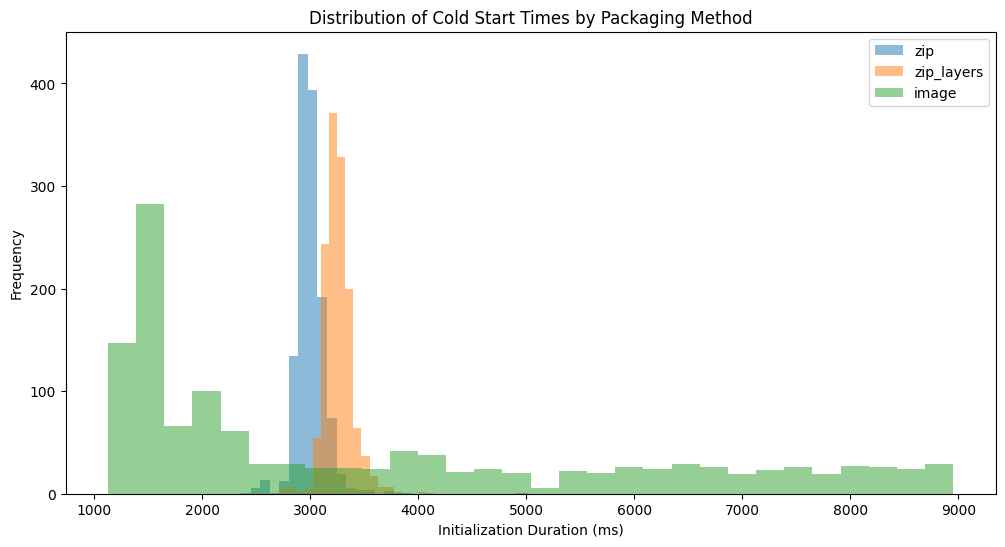

In [183]:
plt.figure(figsize=(12, 6))
for method in df['PackageMethod'].unique():
    subset = df[df['PackageMethod'] == method]
    plt.hist(subset['InitDuration'], bins=30, alpha=0.5, label=method)

plt.title('Distribution of Cold Start Times by Packaging Method')
plt.xlabel('Initialization Duration (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distribution.png', pad_inches=0.3, bbox_inches='tight')
plt.show()

# Find contiguous ranges
To run the benchmark, we run a flood of invocations with intervals of hours in between.
To visualise each invocation separately, we separate the data into contiguous time ranges

In [184]:
df['TimeDiff'] = df['Timestamp'].diff()
threshold = pd.Timedelta(minutes=1)
df['NewRange'] = df['TimeDiff'] > threshold
df['RangeGroup'] = df['NewRange'].cumsum()
df_contiguous_ranges = df.groupby('RangeGroup')['Timestamp'].agg(['min', 'max'])

contiguous_ranges = df_contiguous_ranges.to_records(index=False)
contiguous_ranges

rec.array([('2023-11-27T19:28:11.231000000', '2023-11-27T19:28:20.653000000'),
           ('2023-11-27T21:03:34.406000000', '2023-11-27T21:03:40.621000000'),
           ('2023-11-28T07:49:18.672000000', '2023-11-28T07:49:28.681000000'),
           ('2023-11-28T08:22:19.610000000', '2023-11-28T08:22:27.129000000'),
           ('2023-11-28T09:06:06.742000000', '2023-11-28T09:06:15.204000000')],
          dtype=[('min', '<M8[ns]'), ('max', '<M8[ns]')])

# Plot cold start times by package
Create plots for each contiguous range showing a scatter of cold start times, overlaid with cold start counts and
the P95 cold start time

2023-11-27T19:28:11.231000000 2023-11-27T19:28:20.653000000 5978 2380 2492


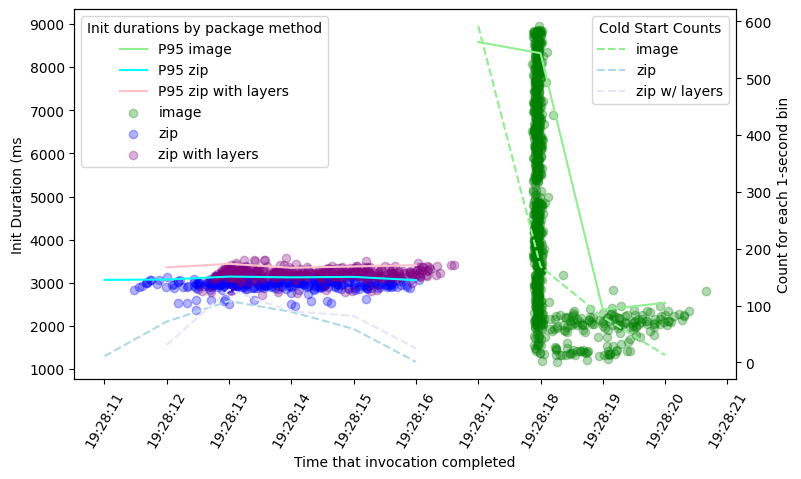

2023-11-27T21:03:34.406000000 2023-11-27T21:03:40.621000000 1183 2443 2730


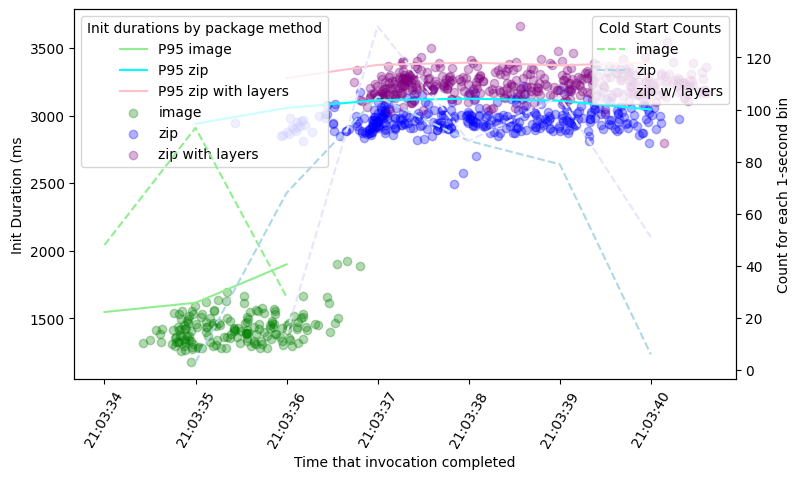

2023-11-28T07:49:18.672000000 2023-11-28T07:49:28.681000000 161 511 497


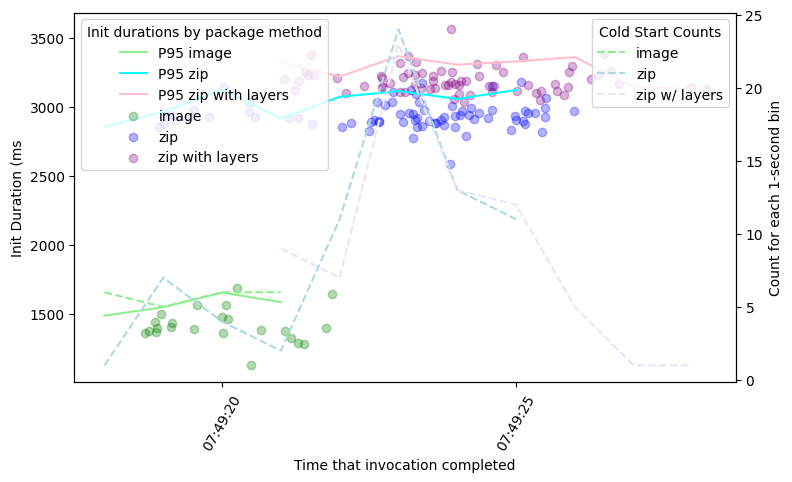

2023-11-28T08:22:19.610000000 2023-11-28T08:22:27.129000000 322 840 833


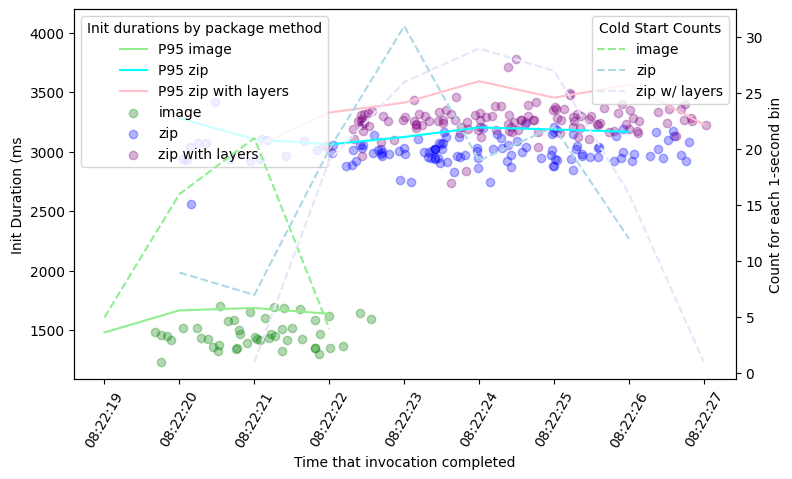

2023-11-28T09:06:06.742000000 2023-11-28T09:06:15.204000000 1274 2884 2905


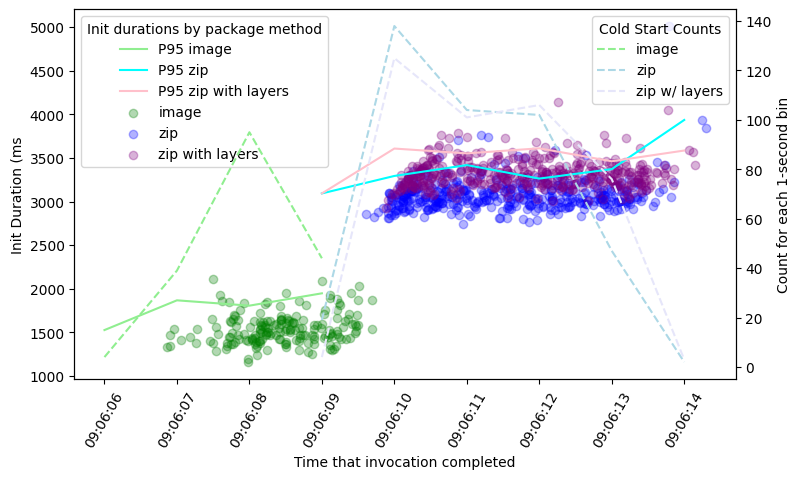

In [185]:
pixel_width, pixel_height = 1280, 720
inches_width, inches_height = pixel_width / dpi, pixel_height / dpi
dpi = 150

for idx, (start_date, end_date) in enumerate(contiguous_ranges):
    range_df = df[(df['Timestamp'] < end_date) & (df['Timestamp'] > start_date)]
    df_image = range_df[range_df['PackageMethod']=='image']
    df_zip = range_df[range_df['PackageMethod']=='zip']
    df_zip_layers= range_df[range_df['PackageMethod']=='zip_layers']
    print(start_date, end_date, df_image.size, df_zip.size, df_zip_layers.size)
    
    def calculate_p95(group):
        return np.percentile(group['InitDuration'], 95)

    # plt.figure(figsize=(inches_width, inches_height))
    fig, ax1 = plt.subplots(figsize=(inches_width, inches_height))
    
    # Create P95 series for each packaging method in 1-second bins
    p95_image = range_df[range_df['PackageMethod'] == 'image'].groupby(pd.Grouper(key='Timestamp', freq='1S')).apply(calculate_p95)
    p95_zip = range_df[range_df['PackageMethod'] == 'zip'].groupby(pd.Grouper(key='Timestamp', freq='1S')).apply(calculate_p95)
    p95_zip_layers = range_df[range_df['PackageMethod'] == 'zip_layers'].groupby(pd.Grouper(key='Timestamp', freq='1S')).apply(calculate_p95)

    # Overlaying P95 lines
    ax1.plot(p95_image.index, p95_image, color='lightgreen', label='P95 image')
    ax1.plot(p95_zip.index, p95_zip, color='cyan', label='P95 zip')
    ax1.plot(p95_zip_layers.index, p95_zip_layers, color='pink', label='P95 zip with layers')

    # Show init duration scatter
    ax1.scatter(df_image['Timestamp'], df_image['InitDuration'], c='green', alpha=0.3, label='image')
    ax1.scatter(df_zip['Timestamp'], df_zip['InitDuration'], c='blue', alpha=0.3, label='zip')
    ax1.scatter(df_zip_layers['Timestamp'], df_zip_layers['InitDuration'], c='purple', alpha=0.3, label='zip with layers')
    
    ax1.set_xlabel('Time that invocation completed')
    ax1.set_ylabel('Init Duration (ms')
    ax1.tick_params(axis='x', rotation=60)

    ax2 = ax1.twinx()
    count_image = range_df[range_df['PackageMethod'] == 'image'].groupby(pd.Grouper(key='Timestamp', freq='1S')).size()
    count_zip = range_df[range_df['PackageMethod'] == 'zip'].groupby(pd.Grouper(key='Timestamp', freq='1S')).size()
    count_zip_layers = range_df[range_df['PackageMethod'] == 'zip_layers'].groupby(pd.Grouper(key='Timestamp', freq='1S')).size()
    ax2.plot(count_image.index, count_image, color='lightgreen', label='image', linestyle='dashed')
    ax2.plot(count_zip.index, count_zip, color='lightblue', label='zip', linestyle='dashed')
    ax2.plot(count_zip_layers.index, count_zip_layers, color='lavender', label='zip w/ layers', linestyle='dashed')

    # Setting ax2 labels
    ax2.set_ylabel('Count for each 1-second bin')
    ax2.tick_params(axis='y')

    ax1.legend(loc='upper left', title='Init durations by package method', )
    ax2.legend(loc='upper right', title='Cold Start Counts')

    plt.savefig(f"{idx}.png", dpi=dpi, pad_inches=0.3, bbox_inches='tight')
    plt.show()

# Assessing memory impact
In order to see if Lambda Function memory size has any impact, we run a separate query to retrieve the same data but with each function's memory allocation added.

In [61]:
quer = logs_client.start_query(
    logGroupNames=log_group_names,
    startTime=int(start_time.timestamp()),
    endTime=int(end_time.timestamp()),
    queryString="""
filter @type = "REPORT"
| filter ispresent(@initDuration)
| parse @log '/aws/lambda/*' as function_name
| filter function_name like 'Python39'
| parse function_name '_*_Python39_*' as pkg_method, mem_cfg
| display @timestamp, pkg_method, mem_cfg, function_name, @initDuration
| sort @timestamp asc
| limit 10000
""")

res = logs_client.get_query_results(queryId=quer['queryId'])
while res['status'] not in ('Complete'):
    if res['status'] in ('Failed', 'Cancelled', 'Timeout'):
        print('Query is in status', res['status'])
        break
    res = logs_client.get_query_results(queryId=quer['queryId'])

In [187]:
mem_data = []
timestamp, pkg_method, mem_cfg, function_name, init_duration = None, None, None, None, None
for (idx, result) in enumerate(res['results']):
    for field in result:
        if field['field'] == '@timestamp':
            timestamp = field['value']
        elif field['field'] == 'pkg_method':
            pkg_method = field['value']
        elif field['field'] == 'mem_cfg':
            mem_cfg = int(field['value'])
        elif field['field'] == 'function_name':
            function_name = field['value']
        elif field['field'] == '@initDuration':
            init_duration = float(field['value'])
    if timestamp is not None and function_name is not None and pkg_method is not None and init_duration is not None:
        mem_data.append([timestamp, function_name, pkg_method, mem_cfg, init_duration])

In [188]:
mem_df = pd.DataFrame(mem_data, columns=['Timestamp', 'FunctionName', 'PackageMethod', 'MemCfg', 'InitDuration'])
mem_df['Timestamp'] = pd.to_datetime(mem_df['Timestamp'])
mem_df.head()

,Timestamp,FunctionName,PackageMethod,MemCfg,InitDuration
0,2023-11-27 19:28:11.231,perf_zip_Python39_3538,zip,3538,2573.46
1,2023-11-27 19:28:11.477,perf_zip_Python39_3538,zip,3538,2834.73
2,2023-11-27 19:28:11.555,perf_zip_Python39_3538,zip,3538,2895.16
3,2023-11-27 19:28:11.595,perf_zip_Python39_3538,zip,3538,2927.63
4,2023-11-27 19:28:11.671,perf_zip_Python39_3538,zip,3538,2993.24


In [189]:
mem_df.drop(columns=['FunctionName', 'Timestamp']).groupby(['PackageMethod', 'MemCfg']).mean().round().apply(lambda x: x.astype(int)).sort_values(['PackageMethod', 'MemCfg'])

InitDuration
PackageMethod MemCfg              
image         1024            3559
              1769            3602
              3538            3591
              10240           3536
zip           1024            3010
              1769            3008
              3538            2986
              10240           3007
zip_layers    1024            3264
              1769            3249
              3538            3252
              10240           3270

# Extract import timing logs

In [82]:
for log_group_name in log_group_names:
    quer = logs_client.start_query(
        logGroupNames=log_group_names,
        startTime=int(start_time.timestamp()),
        endTime=int(end_time.timestamp()),
        queryString="""
    fields @timestamp, @message, @logStream, @log
    | filter @message like 'import time'
    | display @message, @logStream, @log
    | sort @timestamp asc
    | limit 10000
    """)
    
    res = logs_client.get_query_results(queryId=quer['queryId'])
    while res['status'] not in ('Complete'):
        if res['status'] in ('Failed', 'Cancelled', 'Timeout'):
            print('Query is in status', res['status'])
            break
        res = logs_client.get_query_results(queryId=quer['queryId'])

In [85]:
lines = defaultdict(lambda: defaultdict(list))

log, log_stream, message = None, None, None
for (idx, result) in enumerate(res['results']):
    for field in result:
        if field['field'] == '@log':
            log = field['value']
        elif field['field'] == '@logStream':
            log_stream = field['value']
        elif field['field'] == '@message':
            message = field['value']
            
    lines[log][log_stream].append(message)

In [87]:
lines

defaultdict(<function __main__.<lambda>()>,
            {'935672627075:/aws/lambda/perf_image_Python39_10240': defaultdict(list,
                         {'2023/12/08/[$LATEST]26596c7e424a46389655c056b817e5f5': ['import time: self [us] | cumulative | imported package\n',
                           'import time:       274 |        274 |   _io\n',
                           'import time:        40 |         40 |   marshal\n',
                           'import time:       385 |        385 |   posix\n',
                           'import time:       777 |       1475 | _frozen_importlib_external\n',
                           'import time:       212 |        212 |   time\n',
                           'import time:       295 |        507 | zipimport\n',
                           'import time:        94 |         94 |     _codecs\n',
                           'import time:      6494 |       6588 |   codecs\n',
                           'import time:       877 |        877 |   encodings.a

In [89]:
for log, logs_by_stream in lines.items():
    for stream, stream_lines in logs_by_stream.items():
        outdir = f"{log.split('/')[-1]}_{stream.split(']')[-1]}"
        with tempfile.NamedTemporaryFile('w', delete=False) as f:
            f.writelines(stream_lines)
            try:
                !tuna {f.name} -o {outdir}
                print(f"{outdir} generated")
            except:
                print(f"Problem with {log} {stream}")
            # print(res) 

Traceback (most recent call last):
  File "/Users/eoin/miniconda3/envs/perf/bin/tuna", line 8, in <module>
    sys.exit(main())
  File "/Users/eoin/miniconda3/envs/perf/lib/python3.10/site-packages/tuna/cli.py", line 16, in main
    data = read(args.infile)
  File "/Users/eoin/miniconda3/envs/perf/lib/python3.10/site-packages/tuna/main.py", line 19, in read
    return read_import_profile(filename)
  File "/Users/eoin/miniconda3/envs/perf/lib/python3.10/site-packages/tuna/_import_profile.py", line 53, in read_import_profile
    tree = _sort_into_tree(entries[::-1])
  File "/Users/eoin/miniconda3/envs/perf/lib/python3.10/site-packages/tuna/_import_profile.py", line 86, in _sort_into_tree
    last[level - 1]["children"] += [
KeyError: 1
perf_image_Python39_10240_26596c7e424a46389655c056b817e5f5 generated
Traceback (most recent call last):
  File "/Users/eoin/miniconda3/envs/perf/bin/tuna", line 8, in <module>
    sys.exit(main())
  File "/Users/eoin/miniconda3/envs/perf/lib/python3.10/sit

In [90]:
!ls 

0.png
1.png
2.png
3.png
4.png
LICENSE
README.md
app.py
cdk.json
cdk.out
cold_start_viz.ipynb
dashboard_segment.png
distribution.png
lambda_datasci_perf
perf_zip_Python39_3538_2ef4eac4ada048e3b4089e8b543a1e1a
requirements-dev.txt
requirements.txt
scripts
timings_1.png
timings_2.png
timings_3.png


In [91]:
!open perf_zip_Python39_3538_2ef4eac4ada048e3b4089e8b543a1e1a